In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Nazca Integration
This tutorial is about the integration of SolGen with Nazca. To run the provided example both the package SolGen and the sym branch of Nazca are needed. Note that the sym branch of nazca fails to be imported is solver is not found (this can be solved in the future). The sym branch basically provides the function to generate the solver object from the Nazca cell and implements the models for some of the cell provided by demofab (shallow straight, bend and 2x2 MMI). 

Note that all the examples here produced are quite simple, in particular do not have any non optical cell (for example, metal lines and pads). Probably it will not work if extra cells are added. This problem for now is left to future development. 


## Basic Usage

### Getting started, a simple straight waveguide. 
To start to explore the capability of the solver, let's start with the simplest example possible, the straight waveguide. A cell `strt` is created from the demofab pdk. Inside the pdk, the creator of the cell provides a `model_info` dictionary in the cell's attribute containing a model object from the GenSol package.

To create the solver object, the function `get_solver` is used. This takes as input a  Nazca cell and deliver the corresponding solver object. It is important that the cell to be processed has all the relevant pins at top level (in the case of the straight waveguide, pin 'a0' and 'b0') are directly provided by the pdk.

After the generation of the solver, the simulation is carried on in the same way as if the solver were generated manually.

INFO: netlist.py: set pin2pin drc on: True


/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:625: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["left"].set_smart_bounds(True)
/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:628: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["bottom"].set_smart_bounds(True)


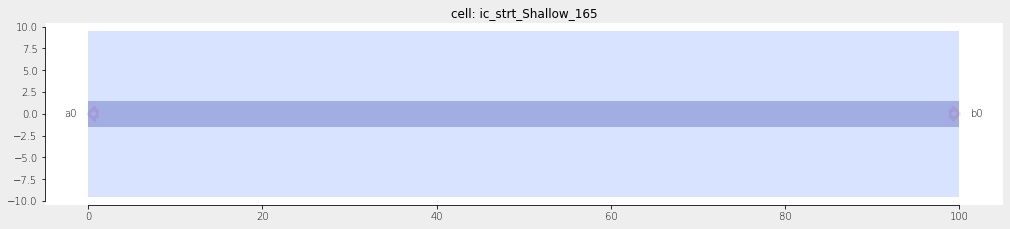

Structures and pins of solver: Solver of ic_strt_Shallow_165 (id=139725420758072))
Structure (id=139725421027624) containing Model of waveguide of lenght 1e+02 (id=139725420923872)

Connection of solver: Solver of ic_strt_Shallow_165 (id=139725420758072))

Free pins of solver: Solver of ic_strt_Shallow_165 (id=139725420758072))
(Structure (id=139725421027624) containing Model of waveguide of lenght 1e+02 (id=139725420923872),    a0) -->    a0
(Structure (id=139725421027624) containing Model of waveguide of lenght 1e+02 (id=139725420923872),    b0) -->    b0

Solver of ic_strt_Shallow_165 (id=139725420758072)
  Model of waveguide of lenght 1e+02 (id=139725420923872)
Transmission= 1.0


In [2]:
import nazca as nd
from nazca import demofab as demo
import solver as sv
import numpy as np
import matplotlib.pyplot as plt

strt=demo.shallow.strt(100.0)
nd.export_plt(topcells=strt)

sol=nd.get_solver(strt)

sol.show_structures()
sol.show_connections()
sol.show_free_pins()
sv.solver_print(sol)

mod=sol.solve(wl=1.55)



print('Transmission=',mod.get_T('a0','b0'))

## Add-drop filter.
Following the same scheme of the GenSol introduction, let's move to a more complex example, the add-drop filter. Usually such a device is made using ring resonators. In this case, the MMI building block from the demofab pdk will be used as coupling element. Keep in mind that for now the model used for the MMI is quite simple, as it simply split the field 50/50, without any phase evolution or wavelength dependence. This may be easily changed by modifying the model object in `model_info` of the MMI cell. 

In this example, the add-drop cell is created by a function, in order to allow the easy creation of cells with different radii. It is important, for the correct operation of the simulator, the define top level pins for all the not connected pins inside the cell. 

INFO: layout.py: Added color to ShallowIcon, (1, 20, None)
INFO: layout.py: Added color to ShallowStub, (1, 10, None)
INFO: layout.py: Added color to ShallowTrenchStub, (2, 10, None)


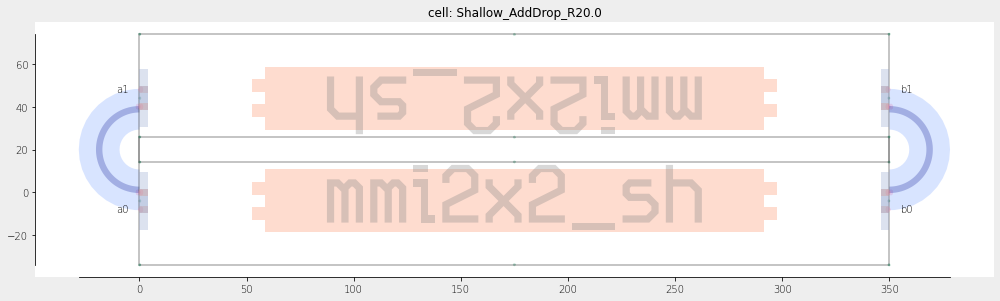

In [3]:
MMI=demo.mmi2x2_sh()

def add_drop(radius):
    with nd.Cell(name=f'Shallow_AddDrop_R{radius:.4}') as C:
        M1=MMI.put()
        demo.shallow.bend(angle=180.0,radius=radius).put()
        M2=MMI.put()    
        demo.shallow.bend(angle=180.0,radius=radius).put()
        nd.Pin('a0').put(M1.pin['a1'])
        nd.Pin('a1').put(M2.pin['b1'])
        nd.Pin('b0').put(M1.pin['b1'])
        nd.Pin('b1').put(M2.pin['a1'])
    return C
        
add_drop_1=add_drop(20.0)

nd.export_plt(topcells=add_drop_1)

After the cell creation, it can be processed with `get_solver`. The function runs though the iterator. For each cells with no model a solver object is created. Each solver object is then filled with the right structures and models, replicating the nazca hierarchy, and the solver object relative to the top cell is returned. After that, the simulation can be done in the conventional way.

<Node(id=6135, name='org') object in cell 'arc_179', xs='None', width=None, xya=(0.000, 0.000, 0.000), type=None, io=None, remark='None'>
<Node(id=6134, name='org') object in cell 'ic_bend_Shallow_178', xs='None', width=None, xya=(0.000, 0.000, 0.000), type=None, io=None, remark='None'>
  <Node(id=6140, name='596_iorg') object in instance of cell 'arc_179', xs='None', width=None, xya=(0.000, 0.000, 0.000), type=None, io=None, remark='None'>
  <Node(id=6140, name='596_iorg') object in instance of cell 'arc_179', xs='None', width=None, xya=(0.000, 0.000, 0.000), type=None, io=None, remark='None'>
    a0 : <Node(id=6142, name='596_a0') object in instance of cell 'arc_179', xs='Shallow', width=3.0, xya=(0.000, 0.000, 180.000), type=None, io=0, remark='None'>
      <Node(id=6144, name='a0') object in cell 'ic_bend_Shallow_178', xs='Shallow', width=3.0, xya=(0.000, 0.000, 180.000), type=None, io=0, remark='None'> : (0.0, 0.0, 0.0)
    b0 : <Node(id=6143, name='596_b0') object in instance of 

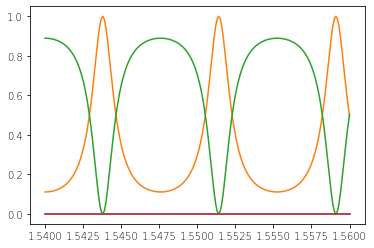

In [4]:
sol=nd.get_solver(add_drop_1, infolevel=1)

sol.show_structures()
sol.show_connections()
sol.show_free_pins()
sv.solver_print(sol)

wl_l=np.linspace(1.54,1.56,201)
res_l=[]
for wl in wl_l:
    mod=sol.solve(wl=wl)
    res_l.append((mod.get_T('a0','a0'),mod.get_T('a0','a1'),mod.get_T('a0','b0'),mod.get_T('a0','b1')))
                 
                 
plt.figure()
plt.plot(wl_l,[t[0] for t in res_l])
plt.plot(wl_l,[t[1] for t in res_l])
plt.plot(wl_l,[t[2] for t in res_l])
plt.plot(wl_l,[t[3] for t in res_l])

### Full hierarchy: the double ring filter
Off course, the newly create cell can be used in the making of other cells, as in the following, were two add-drops are combined to get a double ring filter. In this case, in order to get the transmission spectra of the double ring as well of the single ones, the function `get_solver` is called with the `full_return` option. This returns, instead of only the top cell solver, a dictionary with the solver of all the cells (the keys of the dictionary are the cell's `cnodes` for now). In this way, by calling the solve on the different solvers, all the spectra can be obtained with one loop. 

/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:625: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["left"].set_smart_bounds(True)
/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:628: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["bottom"].set_smart_bounds(True)


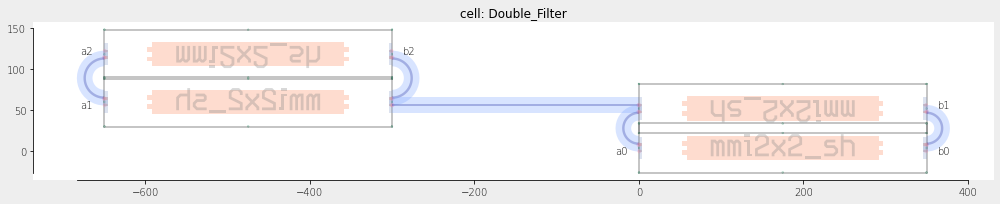

Structures and pins of solver:       Solver of Double_Filter (id=139725413285000))
Structure (id=139725413307392) containing Solver of Shallow_AddDrop_R20.0 (id=139725413307336)
Structure (id=139725211485128) containing Solver of ic_strt_Shallow_192 (id=139725211485072)
Structure (id=139725211486752) containing Solver of Shallow_AddDrop_R25.0 (id=139725211486696)

Connection of solver:       Solver of Double_Filter (id=139725413285000))
(Structure (id=139725413307392) containing Solver of Shallow_AddDrop_R20.0 (id=139725413307336),    a1) <--> (Structure (id=139725211485128) containing Solver of ic_strt_Shallow_192 (id=139725211485072),    a0)
(Structure (id=139725211485128) containing Solver of ic_strt_Shallow_192 (id=139725211485072),    b0) <--> (Structure (id=139725211486752) containing Solver of Shallow_AddDrop_R25.0 (id=139725211486696),    a0)

Free pins of solver:       Solver of Double_Filter (id=139725413285000))
(Structure (id=139725413307392) containing Solver of Shallow_Ad

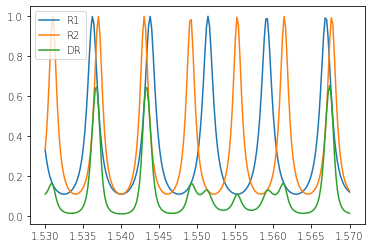

In [5]:
ad_R10=add_drop(20.0)
ad_R12=add_drop(25.0)

with nd.Cell(name='Double_Filter') as DF:
    r1=ad_R10.put()
    demo.shallow.strt(300.0).put(r1.pin['a1'])
    r2=ad_R12.put(flip=True)
    
    nd.Pin('a0').put(r1.pin['a0'])
    nd.Pin('a1').put(r2.pin['b0'])
    nd.Pin('a2').put(r2.pin['b1'])
    nd.Pin('b0').put(r1.pin['b0'])
    nd.Pin('b1').put(r1.pin['b1'])
    nd.Pin('b2').put(r2.pin['a1'])
    
    
nd.export_plt(topcells=DF)

sol=nd.get_solver(DF, fullreturn=True)

sol[DF.cnode].show_structures()
sol[DF.cnode].show_connections()
sol[DF.cnode].show_free_pins()
sv.solver_print(sol[DF.cnode])

wl_l=np.linspace(1.53,1.57,201)
res_l=[]
for wl in wl_l:
    R1=sol[ad_R10.cnode].solve(wl=wl)
    R2=sol[ad_R12.cnode].solve(wl=wl)
    mod=sol[DF.cnode].solve(wl=wl)
    res_l.append((R1.get_T('a0','a1'),R2.get_T('a0','a1'),mod.get_T('a0','b2')))
                 
                 
plt.figure()
plt.plot(wl_l,[t[0] for t in res_l], label='R1')
plt.plot(wl_l,[t[1] for t in res_l], label='R2')
plt.plot(wl_l,[t[2] for t in res_l], label='DR')
plt.legend()

## More advanced features
### Model definition
Sometimes, the user would like to define a custom model for a nazca cell. This is done directly assign inserting a model object in the `model_info` dictionary of the cell. The interior of the cell can be drawn as usual, however will not have any consequence in the simulation, since all the information is taken from the model and interior of the cell is not analyzed. All the model's port need to have a pin in the cell with the same name. The cell can also have pins which are not in the model, and that will be ignored in the simulation. 

Below is an example of the definition of a thermal phase shifter, with optical pins for waveguides and electrical pins for the "heater".

Furthermore, the model used for the phase shifter has an internal parameter, named 'PS', which represent the applied phase shift in pi units, and that can be set by passing it as a keyword argument to solve. 

/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:625: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["left"].set_smart_bounds(True)
/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:628: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["bottom"].set_smart_bounds(True)


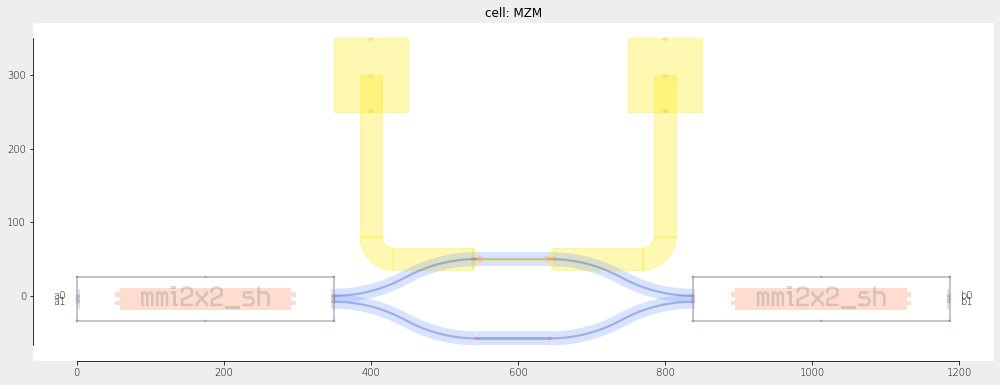

Text(0, 0.5, 'Transmission')

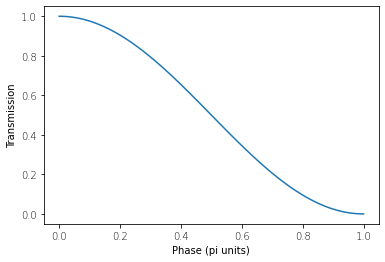

In [6]:

xsShallow=nd.get_xsection('Shallow')
with nd.Cell(name='PhaseShifter') as PS:
    t1=demo.metaldc.taper(width2=2.0,length=10.0).put()
    demo.metaldc.strt(90.0,width=2.0).put()
    t2=demo.metaldc.taper(width1=2.0,length=10.0).put()
    
    wg=demo.shallow.strt(100.0).put(5.0,0.0,0.0)
    
    nd.Pin('c0').put(t1.pin['a0'])
    nd.Pin('c1').put(t2.pin['b0'])
    nd.Pin('a0').put(wg.pin['a0'])
    nd.Pin('b0').put(wg.pin['b0'])
    
    PS.model_info['model']=sv.TH_PhaseShifter(100.0,xsShallow.Neff)
    
with nd.Cell(name='DC_pad') as DCp:
    demo.metaldc.strt(100.0,width=100.0).put(-50.0,0,0)
    nd.Pin('a0').put(0,0,90.0)
    
    
with nd.Cell(name='MZM') as MZM:
    m1=MMI.put()
    demo.shallow.sbend(offset=50.0).put()
    ps=PS.put()
    #demo.shallow.strt(100.0).put()
    demo.shallow.sbend(offset=-50.0).put()
    m2=MMI.put()
    demo.shallow.sbend(offset=-50.0).put(m1.pin['b1'])
    demo.shallow.strt(100.0).put()
    demo.shallow.sbend(offset=50.0).put()
    
    DCp.put(400.0,300.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps.pin['c0']).put()
    DCp.put(800.0,300.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps.pin['c1']).put()
    
    nd.Pin('a0').put(m1.pin['a0'])
    nd.Pin('a1').put(m1.pin['a1'])
    nd.Pin('b0').put(m2.pin['b0'])
    nd.Pin('b1').put(m2.pin['b1'])
    
        
        
nd.export_plt(topcells=MZM)

sol=nd.get_solver(MZM)

sol.solve(wl=1.55)

psl=np.linspace(0.0,1.0,101)
T=[sol.solve(wl=1.55,PS=ps).get_T('a0','b0') for ps in psl]
plt.plot(psl,T)
plt.xlabel('Phase (pi units)')
plt.ylabel('Transmission')

### Multiple parameters
In the previous example, the parameter's name of the parametric block was fixed, and was the same for all instanced of the cell 'PS'. This severely limits the flexibility of the tool, since and arbitrary number of thermal phase shifter may be need in a design, and fine control an all of them is needed.


For this reason, an option for renaming the parameters inside a cell is added to the put statement. When placing an instance of a cell containing some parametric models, just pass a 'param_mapping' dictionary (mapping `{old_parameter_name : new_parameter_name}`) to the put statement. The parameter for that instance will be renamed according to the mapping. In this way, it is possible to assign to each instance of a parametric cell a unique parameter name, in order to finely control the simulation. 

Here is an example of the same MZM as before, but with  a phase shifter in each arm.

/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:625: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["left"].set_smart_bounds(True)
/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:628: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["bottom"].set_smart_bounds(True)


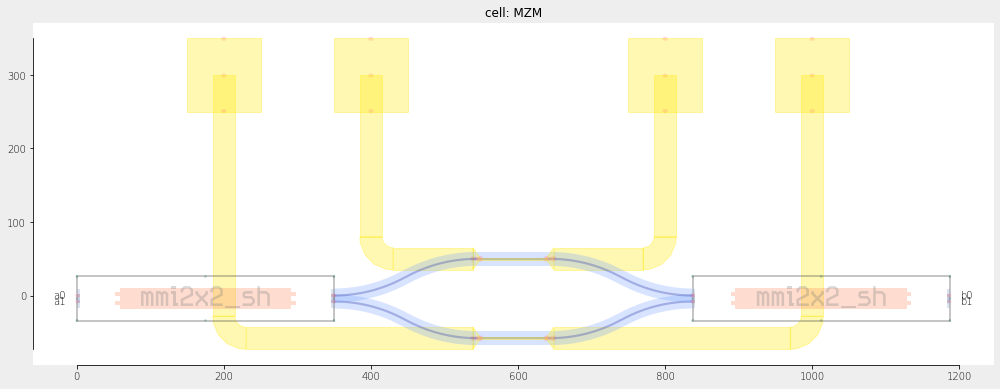

Text(0, 0.5, 'Transmission')

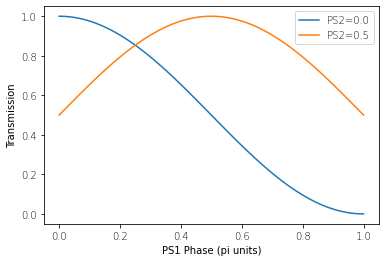

In [7]:
with nd.Cell(name='MZM') as MZM_bal:
    m1=MMI.put()
    demo.shallow.sbend(offset=50.0).put()
    ps=PS.put(param_mapping={'PS': 'PS1'})
    demo.shallow.sbend(offset=-50.0).put()
    m2=MMI.put()
    demo.shallow.sbend(offset=-50.0).put(m1.pin['b1'])
    ps2=PS.put(param_mapping={'PS': 'PS2'})
    demo.shallow.sbend(offset=50.0).put()
    
    DCp.put(400.0,300.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps.pin['c0']).put()
    DCp.put(800.0,300.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps.pin['c1']).put()

    DCp.put(200.0,300.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps2.pin['c0']).put()
    DCp.put(1000.0,300.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps2.pin['c1']).put()
    
    
    nd.Pin('a0').put(m1.pin['a0'])
    nd.Pin('a1').put(m1.pin['a1'])
    nd.Pin('b0').put(m2.pin['b0'])
    nd.Pin('b1').put(m2.pin['b1'])
    
nd.export_plt(topcells=MZM_bal)

sol=nd.get_solver(MZM_bal)


psl=np.linspace(0.0,1.0,101)
T1=[sol.solve(wl=1.55,PS1=ps).get_T('a0','b0') for ps in psl]
T2=[sol.solve(wl=1.55,PS1=ps,PS2=0.5).get_T('a0','b0') for ps in psl]

plt.plot(psl,T1, label='PS2=0.0')
plt.plot(psl,T2, label='PS2=0.5')
plt.legend()
plt.xlabel('PS1 Phase (pi units)')
plt.ylabel('Transmission')

### Multiple renaming and more complex circuits:
An important feature of the parameter renaming feature, is that it can be done at multiple levels and even on already mapped parameters. For example, we could use a 2 MZM similar to before (with a 'PS1' and a 'PS2' parameters already renamed) to build a more complex IQ modulator, renaming 'PS1' and 'PS2' of both MZM when we place them. This allow the building of complex circuit with the least amount of programming overhead, since once defined every parametric cell can be reused multiple times without losing control of the individual parameters.

/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:625: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["left"].set_smart_bounds(True)
/home/marco/Documents/Programs/NAZCA/git_nazca/nazca/layout.py:628: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines["bottom"].set_smart_bounds(True)


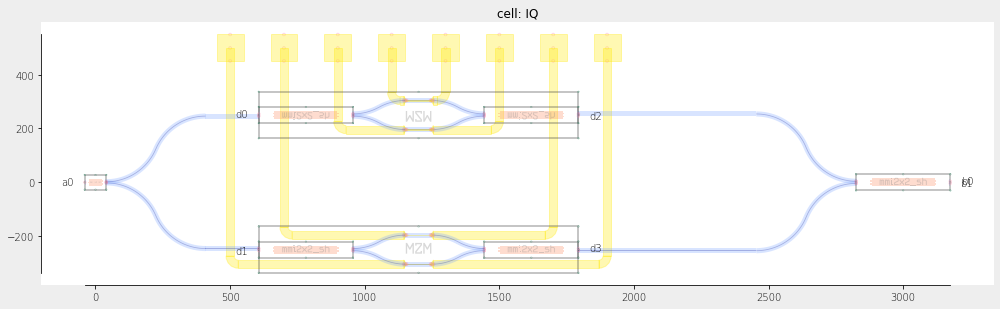

Structures and pins of solver:                  Solver of IQ (id=139725343798160))
Structure (id=139725343798440) containing Model of 1x2 splitter (id=139725343798384)
Structure (id=139725343798608) containing Model of beam-splitter with ratio 0.5 (id=139725343798552)
Structure (id=139725343798776) containing Solver of MZM (id=139725343798720)
Structure (id=139725343493312) containing Solver of MZM (id=139725343493256)
Structure (id=139725343138760) containing Solver of ic_sbend_Shallow_326 (id=139725343138704)
Structure (id=139725343160416) containing Solver of ic_sbend_Shallow_333 (id=139725343160360)
Structure (id=139725343190264) containing Solver of ic_sbend_Shallow_340 (id=139725343190208)
Structure (id=139725343248848) containing Solver of ic_sbend_Shallow_347 (id=139725343248792)

Connection of solver:                  Solver of IQ (id=139725343798160))
(Structure (id=139725343798440) containing Model of 1x2 splitter (id=139725343798384),    b0) <--> (Structure (id=139725343138

[]

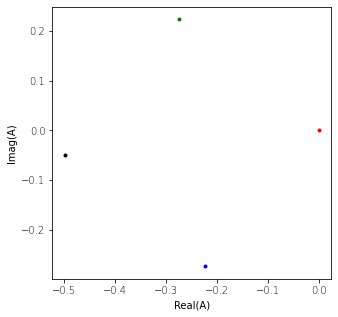

In [8]:
with nd.Cell(name='MZM', autobbox=True) as MZM_bal:
    m1=MMI.put()
    demo.shallow.sbend(offset=50.0).put()
    ps=PS.put(param_mapping={'PS': 'PS1'})
    demo.shallow.sbend(offset=-50.0).put()
    m2=MMI.put()
    demo.shallow.sbend(offset=-50.0).put(m1.pin['b1'])
    ps2=PS.put(param_mapping={'PS': 'PS2'})
    demo.shallow.sbend(offset=50.0).put()    
    
    nd.Pin('a0').put(m1.pin['a0'])
    nd.Pin('a1').put(m1.pin['a1'])
    nd.Pin('b0').put(m2.pin['b0'])
    nd.Pin('b1').put(m2.pin['b1'])

    nd.Pin('c0').put(ps.pin['c0'])
    nd.Pin('c1').put(ps.pin['c1'])
    nd.Pin('c2').put(ps2.pin['c0'])
    nd.Pin('c3').put(ps2.pin['c1'])
    
    

MMI1x2=demo.mmi1x2_sh()
with nd.Cell(name='IQ') as IQ:
    m1=MMI1x2.put('cc',0,0,180)
    m2=MMI.put('cc',3000.0,0,180)
    mzm1=MZM_bal.put('cc',1200.0,250,180,flip=True,param_mapping={'PS1' : 'I1', 'PS2' : 'I2'})
    mzm2=MZM_bal.put('cc',1200.0,-250,180,param_mapping={'PS1' : 'Q1', 'PS2' : 'Q2'})
    
    demo.shallow.sbend_p2p(m1.pin['b0'],mzm1.pin['a0']).put()
    demo.shallow.sbend_p2p(m1.pin['b1'],mzm2.pin['a0']).put()
    demo.shallow.sbend_p2p(m2.pin['a0'],mzm1.pin['b1']).put()
    demo.shallow.sbend_p2p(m2.pin['a1'],mzm2.pin['b1']).put()
    
    nd.Pin('a0').put(m1.pin['a0'])
    nd.Pin('b0').put(m2.pin['b0'])
    nd.Pin('b1').put(m2.pin['b1'])

    nd.Pin('d0').put(mzm1.pin['a1'])
    nd.Pin('d1').put(mzm2.pin['a1'])
    nd.Pin('d2').put(mzm1.pin['b0'])
    nd.Pin('d3').put(mzm2.pin['b0'])
    

    DCp.put(500.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm2.pin['c2']).put()
    DCp.put(700.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm2.pin['c0']).put()
    DCp.put(900.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm1.pin['c0']).put()
    DCp.put(1100.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm1.pin['c2']).put()
    DCp.put(1300.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm1.pin['c3']).put()
    DCp.put(1500.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm1.pin['c1']).put()
    DCp.put(1700.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm2.pin['c1']).put()
    DCp.put(1900.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm2.pin['c3']).put()
    
    
nd.export_plt(topcells=IQ)
sol=nd.get_solver(IQ)

sol.show_structures()
sol.show_connections()
sol.show_free_pins()
sv.solver_print(sol)

plt.figure(figsize=[5.0,5.0])
A=sol.solve(wl=1.55,I1=0.0,I2=0.0,Q1=0.0,Q2=0.0).get_A('a0','b0')
plt.plot(A.real,A.imag,'.r')
A=sol.solve(wl=1.55,I1=0.5,I2=0.0,Q1=0.0,Q2=0.0).get_A('a0','b0')
plt.plot(A.real,A.imag,'.g')
A=sol.solve(wl=1.55,I1=0.0,I2=0.0,Q1=0.5,Q2=0.0).get_A('a0','b0')
plt.plot(A.real,A.imag,'.b')
A=sol.solve(wl=1.55,I1=0.5,I2=0.0,Q1=0.5,Q2=0.0).get_A('a0','b0')
plt.plot(A.real,A.imag,'.k')
plt.xlabel('Real(A)')
plt.ylabel('Imag(A)')

plt.plot()

